White Island Levelling Data Maps
--

In [1]:
import pandas as pd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import requests

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import StamenTerrain

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout

%matplotlib inline

In [2]:
#full width notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

**Widget functions**

In [3]:
def seld1(wd1):
  global date1
  date1 = wd1['new']
    
def seld2(wd2):
  global date2
  date2 = wd2['new']

In [28]:
def go(g):
  global diff, signif
  #dataframes for each date  
  data1 = dfall[dfall['Datetime']==date1]
  data2 = dfall[dfall['Datetime']==date2]
  #difference dataframe, for plotting
  diff = pd.merge(data2, data1, on='siteID')  
  diff['diff'] = (diff['obs_x'] - diff['obs_y']) * 1000

  maxval = max(abs(diff['diff'].min()), abs(diff['diff'].max()))
  vmin = maxval * -1
  vmax = maxval
  
  #plot map
  fig = plt.figure()
  
  #imagery
  imagery = OSM()  
  ax = plt.axes(projection=imagery.crs)
  ax.add_image(imagery, 14)
  ax.set_extent([float(lonmin), float(lonmax), float(latmin), float(latmax)])
      
  #observations as coloured points
  plt.scatter(diff['lon_x'], diff['lat_x'], c=diff['diff'], s=50, marker='o', linewidth=0, cmap='seismic', vmin=vmin, vmax=vmax, norm=matplotlib.colors.Normalize(), transform=ccrs.Geodetic())
  
  ##value labels inside symbols
  geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
  text_transform = offset_copy(geodetic_transform, units='dots', x=0, y=0)
  for value, x, y in zip(diff['diff'], diff['lon_x'], diff['lat_x']):
    plt.text(x, y, str(int(round(value))), size=4, color='white', verticalalignment='center', horizontalalignment='center', transform=text_transform)
    
  #plot reference site (WI100, A) as star
  ref = diff[diff['siteID']=='WI100']
  plt.plot(ref['lon_x'], ref['lat_x'], color='black', markersize=10, marker='*', linestyle='None', transform=ccrs.Geodetic())

  #colour bar
  cb = plt.colorbar()
  cb.set_label('Height change (mm)')

  #title
  title = date1+' to '+date2
  plt.title(title)

  #save as file
  image = date1+'-'+date2+'.png'
  plt.savefig(image, dpi=200)

**Data search parameters**

In [5]:
typeID = 'z'
methodID = 'lev'
latmin = '-37.528'
latmax = '-37.518'
lonmin = '177.184'
lonmax = '177.196'

within = 'POLYGON(('+lonmin+'+'+latmax+','+lonmin+'+'+latmin+','+lonmax+'+'+latmin+','+lonmax+'+'+latmax+','+lonmin+'+'+latmax+'))'

**Query**

In [6]:
url = 'http://fits.geonet.org.nz/site'
payload = {'typeID': typeID, 'methodID': methodID, 'within': within}

**Get sites from site query**

In [7]:
r = requests.get(url,params=payload)
jdata = r.json()
features = jdata['features']
dfsite = pd.DataFrame() #empty dataframe
for i, val in enumerate(features):
  geometry = val['geometry']
  lon = geometry['coordinates'][0]
  lat = geometry['coordinates'][1]
  properties = val['properties']
  siteID = properties['siteID']
  height = properties['height']
  name = properties['name']
  #append these to df
  dfsite = dfsite.append({'siteID': siteID, 'lon': lon, 'lat': lat, 'height': height, 'name': name}, ignore_index=True)

In [8]:
dfsite.head()

,height,lat,lon,name,siteID
0,0.000,-37.525886,177.191399,White Island Level A,WI100
1,5.777,-37.523688,177.188405,White Island Level C,WI102
2,7.869,-37.523524,177.187954,White Island Level D1,WI103-1
3,9.568,-37.523524,177.187954,White Island Level D2,WI103-2
4,10.429,-37.523524,177.187954,White Island Level D3,WI103-3


**For each siteID, get time-series data and accumulate**

In [9]:
names = ['dt', 'obs', 'err']
dfts = pd.DataFrame()   #empty dataframe

In [10]:
for site in dfsite['siteID']:
  site = site.encode('ascii','ignore')
  #print site, network
  url= 'https://fits.geonet.org.nz/observation?typeID='+typeID+'&siteID='+site+'&methodID='+methodID
  df = pd.read_csv(url, names=names, skiprows=1, parse_dates={"Datetime" : ['dt']})
  df['siteID'] = site
  dfts = dfts.append(df, ignore_index=True)

**Merge the two dataframes on siteID**

In [11]:
dfall = pd.merge(dfsite, dfts, on='siteID')

**Get a list of dates (as strings) for selection with a widget**

In [12]:
dates = dfall['Datetime'].unique()
datestr = dates.astype('datetime64[D]').astype('str').tolist()
datestr.sort()
datestr.append('choose date')
datestr.reverse()

**Date selection section using widgets**

Widget Javascript not detected.  It may not be installed or enabled properly.


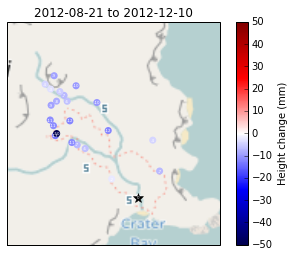

In [29]:
wd1 = widgets.Select(
    options= datestr,
    description='earlier date:',
    disabled=False
)
wd1.observe(seld1, names='value')

wd2 = widgets.Select(
    options= datestr,
    description='later date:',
    disabled=False
)
wd2.observe(seld2, names='value')

g=widgets.Button(
    description='Plot and make file',
    disabled=False,
    button_style='success',
    tooltip='Click to plot')
g.on_click(go)

widgets.HBox([wd1, wd2, g])

**Look at selected data in different ways**

**Histogram of changes vs siteID**

In [14]:
dh = diff.plot(kind='bar', x='siteID', y='diff', legend=False)
plt.axhline(0, color='black')
plt.axhline(12, color='red', linestyle='--')
plt.axhline(-12, color='red', linestyle='--')
dh.set_ylabel('Height change (mm)')

NameError: name 'diff' is not defined

**SiteID vs site name, to help users**

In [ ]:
pd.set_option('display.max_columns', 23) #increase column numbers to show all
text = diff[['siteID', 'name_x']].copy().transpose()
text

In [ ]:
#then reset
pd.reset_option('display.max_columns')

**Boxplot of all changes**

In [ ]:
db = diff.plot(kind='box', y='diff', legend=False)
plt.axhline(12, color='red', linestyle='--')
plt.axhline(-12, color='red', linestyle='--')
plt.axhline(0, color='red', linestyle='-')
db.set_ylabel('Height change (mm)')